In [3]:
!python -m pip install pymongo

In [40]:
import pymongo
from pymongo import MongoClient

import pandas as pd
import numpy as np

In [306]:
def get_data():
    
    # Grabbing Mongo collection
    client = MongoClient('localhost', 27017)
    db = client["THC"]
    politicians = db.get_collection("politicians")

    # Quering all documents and processing it afterwards
    def change_speeches_to_count(document):
        document["speeches"] = len(document["speeches"])
        return document
    
    data = [change_speeches_to_count(document) for document in list(politicians.find())]
    
    return pd.DataFrame(data)

In [307]:
df = get_data()

In [308]:
# Dropping columns that we will not use
df.drop(columns=["_id", "hash", "school", "election_date", 'political_group', "oath_date", "date_of_birth","profession",
                 "email"],
        inplace=True)

In [309]:
# Changing parliment_member to parliment_count
df.rename(columns={'parliment_member': 'parliment_member_count'}, inplace=True)
df["parliment_member_count"] = df["parliment_member_count"].map(len)

In [310]:
df["sex"] = df["sex"].map({"man": "Mężczyzna", "woman": "Kobieta"})

In [312]:
df["academic_degree"].fillna(df["education"], inplace=True)
df.drop(columns="education", inplace=True)

mapping = {k:k.strip() for k, _ in df["academic_degree"].value_counts().to_dict().items()}
map_dict = {'zasadnicze zawodowe': "średnie", ' Doctor of Philosophy (Ph.D.)': "doktor"}

for key in current_mapping.keys():
    for education_part in ["średnie", "profesor"]:
        if education_part in key:
            map_dict[key] = education_part
            
mapping.update(map_dict)

df = (df
      .assign(academic_degree = df["academic_degree"]
                                .map(mapping)
                                .fillna("wyższe"))
      .rename(columns={'academic_degree': 'education'}))

In [313]:
df = df[df["election_list"] != "Mniejszość Niemiecka"]

In [341]:
df["age_bins"] = pd.cut(df["age"], bins=range(20,90,15))

In [342]:
df["age_bins"].value_counts()

(50, 65]    206
(35, 50]    169
(65, 80]     47
(20, 35]     42
Name: age_bins, dtype: int64

In [347]:
df["speeches_capped"] = df["speeches"].clip(upper=100)
df["speeches_bins"] = pd.cut(df["speeches_capped"], bins=range(-10,110,10))

In [348]:
df["speeches_bins"].value_counts().sum()

464

# Analiza partii

In [314]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme(style="ticks")

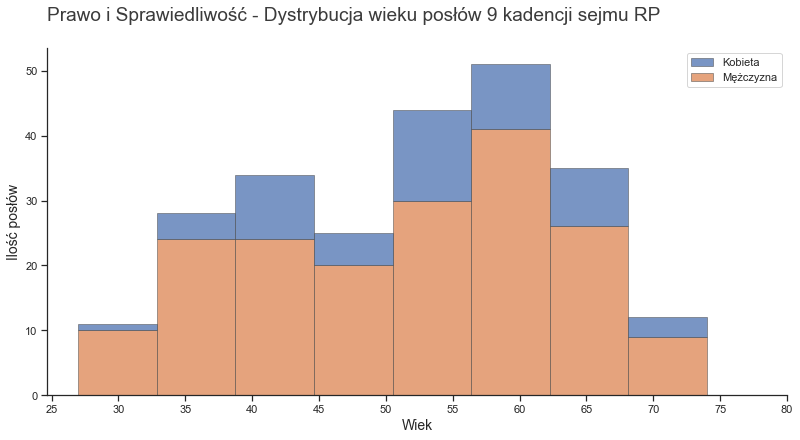

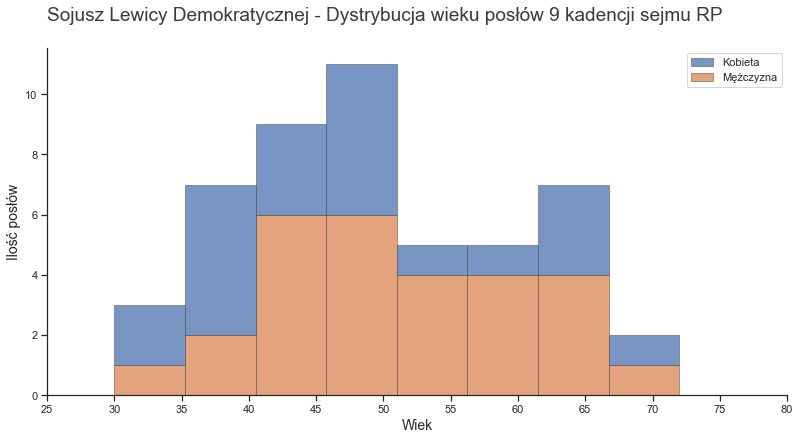

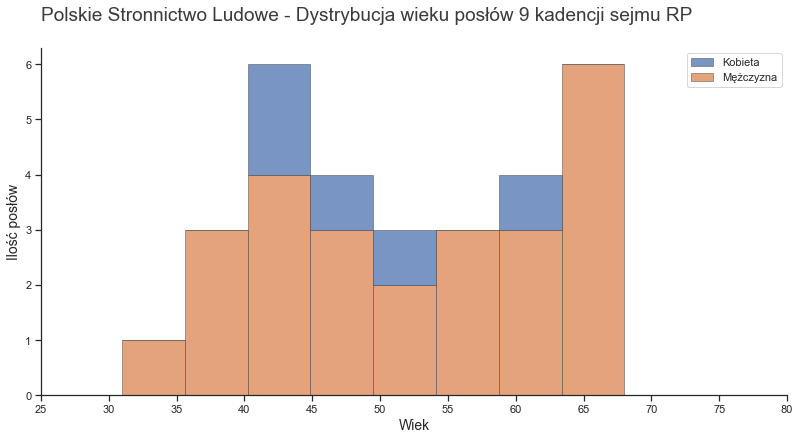

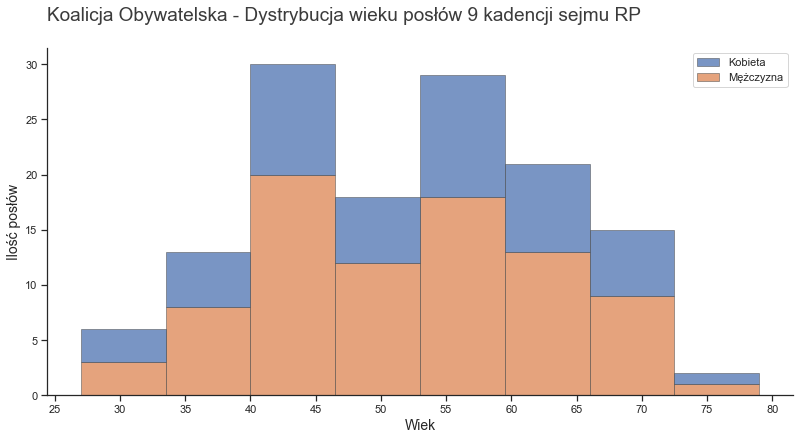

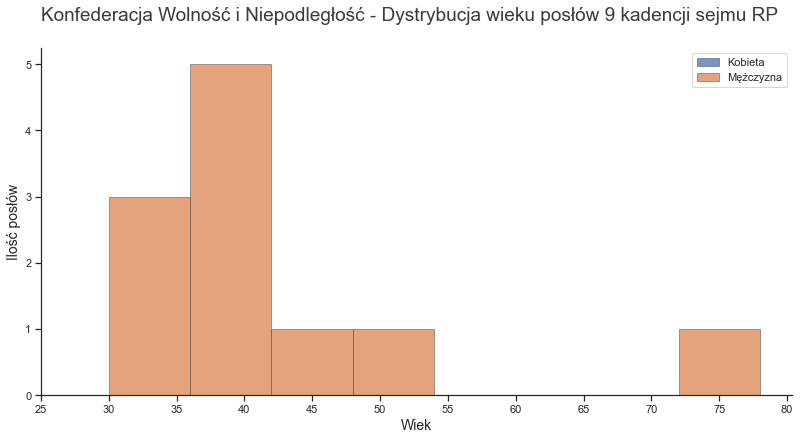

In [315]:
for election_list in df["election_list"].unique():
    
    f, ax = plt.subplots(constrained_layout=True, figsize=(11,6))
    
    sns.despine(f)

    plot = sns.histplot(
            df[df["election_list"] == election_list],
            x="age",
            hue="sex",
            bins=8,
            hue_order=df["sex"].value_counts().index[::-1],
            multiple="stack",
            palette=sns.color_palette("deep", 2),
            edgecolor=".3",
            linewidth=.5,
        )
    plot.get_legend().set_title("")
    plot.set_xlabel("Wiek", size=14)
    plot.set_ylabel("Ilość posłów", size=14)
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    _ = ax.set_xticks(range(25,85,5))
    _ = plt.title(f"{election_list} - Dystrybucja wieku posłów 9 kadencji sejmu RP\n", size=19, alpha=0.9, loc="left")
    plt.show()

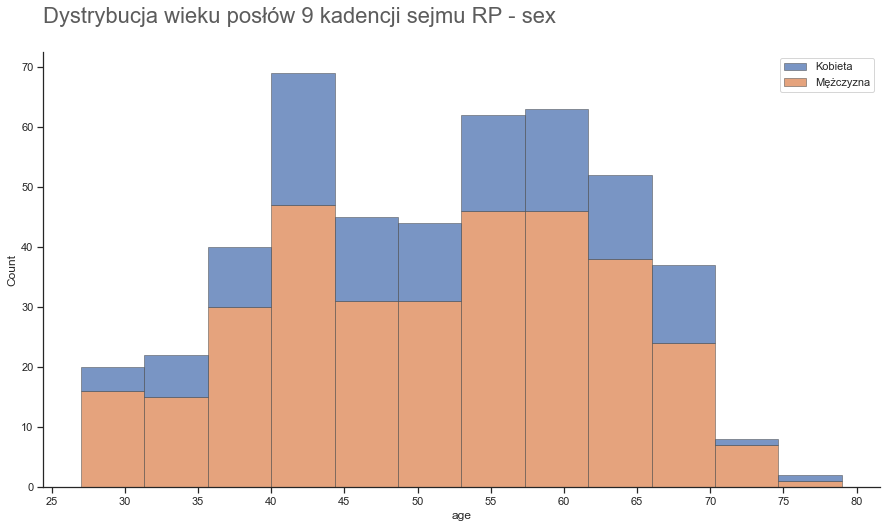

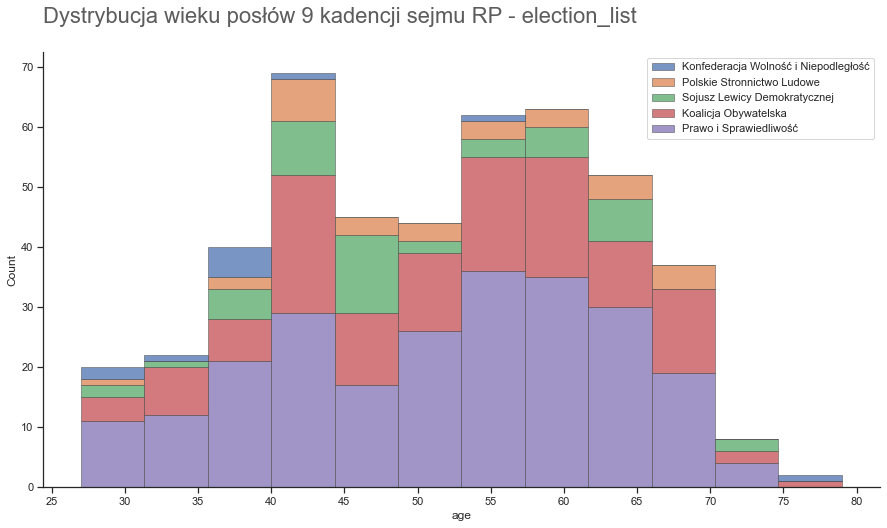

In [320]:
for category in ["sex", "election_list"]:
    f, ax = plt.subplots(figsize=(15, 8))
    sns.despine(f)

    plot = sns.histplot(
        df,
        x="age",
        hue=category,
        hue_order=df[category].value_counts().index[::-1],
        multiple="stack",
        palette=sns.color_palette("deep", df[category].nunique()),
        edgecolor=".3",
        linewidth=.5,
    )

    plot.get_legend().set_title("")
    
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    _ = ax.set_xticks(range(25,85,5))    
    _ = plt.title(f"Dystrybucja wieku posłów 9 kadencji sejmu RP - {category}\n", size=22, alpha=0.75, loc="left")
    
    plt.show()

In [411]:
print("Odsetek posłów z zerem przemówień:")

((df[df["speeches"] == 0]["election_list"].value_counts(sort=False) /
  df["election_list"].value_counts(sort=False))
  .fillna(0)
  .mul(100)).map(lambda value: str(int(value)) + "%") 

Odsetek posłów z zerem przemówień:


Koalicja Obywatelska                     4%
Konfederacja Wolność i Niepodległość     0%
Polskie Stronnictwo Ludowe               6%
Prawo i Sprawiedliwość                  27%
Sojusz Lewicy Demokratycznej             2%
Name: election_list, dtype: object

In [414]:
print("Odsetek posłów którzy mieli 20 lub więcej przemówień:")

((df[df["speeches"] >= 20]["election_list"].value_counts(sort=False) /
  df["election_list"].value_counts(sort=False))
  .fillna(0)
  .mul(100)).map(lambda value: str(int(value)) + "%") 

Odsetek posłów którzy mieli 20 lub więcej przemówień:


Koalicja Obywatelska                    38%
Konfederacja Wolność i Niepodległość    90%
Polskie Stronnictwo Ludowe              40%
Prawo i Sprawiedliwość                   9%
Sojusz Lewicy Demokratycznej            69%
Name: election_list, dtype: object

In [395]:
df["election_list"].value_counts(sort=False)

Polskie Stronnictwo Ludowe               30
Prawo i Sprawiedliwość                  240
Sojusz Lewicy Demokratycznej             49
Konfederacja Wolność i Niepodległość     11
Koalicja Obywatelska                    134
Name: election_list, dtype: int64

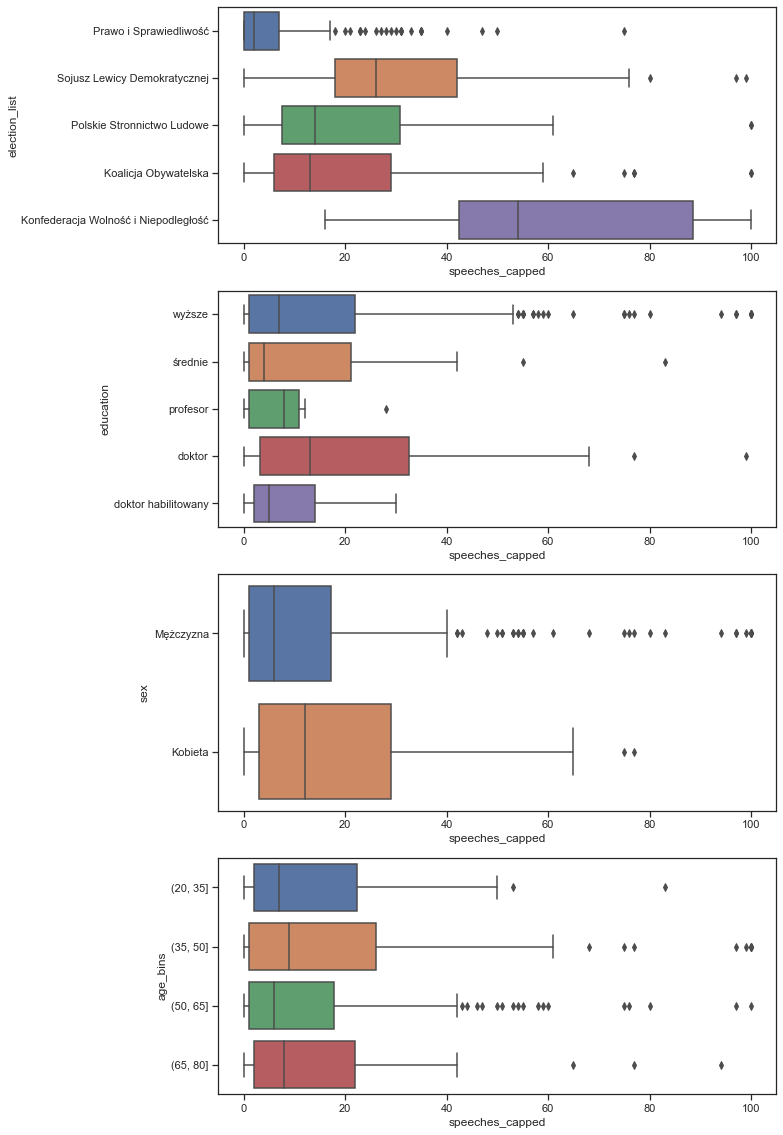

In [435]:
fig, axes = plt.subplots(4,1, figsize=(10,20))

for ax_n, column in enumerate(["election_list",
                               "education",
                               "sex",
                               "age_bins"]):
    ax = axes.flatten()[ax_n]

    sns.boxplot(x="speeches_capped", y=column, data=df, ax=ax)

In [437]:
print("Odsetek posłów z zerem przemówień:")

((df[df["speeches"] == 0]["age_bins"].value_counts(sort=False) /
  df["age_bins"].value_counts(sort=False))
  .fillna(0)
  .mul(100)).map(lambda value: str(int(value)) + "%") 

Odsetek posłów z zerem przemówień:


(20, 35]    11%
(35, 50]    17%
(50, 65]    17%
(65, 80]    10%
Name: age_bins, dtype: object

In [438]:
print("Odsetek posłów z zerem przemówień:")

((df[df["speeches"] == 0]["education"].value_counts(sort=False) /
  df["education"].value_counts(sort=False))
  .fillna(0)
  .mul(100)).map(lambda value: str(int(value)) + "%") 

Odsetek posłów z zerem przemówień:


doktor                  9%
doktor habilitowany    22%
profesor               22%
wyższe                 16%
średnie                20%
Name: education, dtype: object

In [439]:
print("Odsetek posłów z zerem przemówień:")

((df[df["speeches"] == 0]["sex"].value_counts(sort=False) /
  df["sex"].value_counts(sort=False))
  .fillna(0)
  .mul(100)).map(lambda value: str(int(value)) + "%") 

Odsetek posłów z zerem przemówień:


Mężczyzna    19%
Kobieta       9%
Name: sex, dtype: object

In [447]:
beton = df.pivot_table(columns="parliment_member_count", index="election_list", values="name", aggfunc="count", fill_value=0)

<AxesSubplot:xlabel='parliment_member_count', ylabel='election_list'>

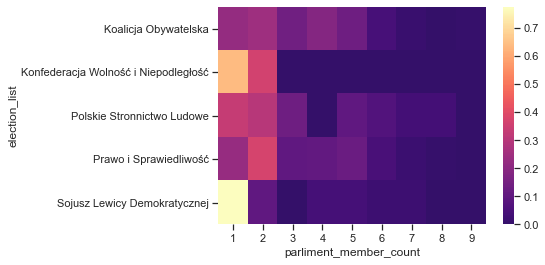

In [481]:
sns.heatmap((beton.transpose() / beton.sum(axis=1)).transpose(), cmap="magma", center=0.3)

In [486]:
df[df["parliment_member_count"] >= 7][["name", "election_list", "parliment_member_count"]]

,name,election_list,parliment_member_count
14,Grzegorz Schetyna,Koalicja Obywatelska,7
19,Marek Sawicki,Polskie Stronnictwo Ludowe,8
26,Antoni Macierewicz,Prawo i Sprawiedliwość,7
74,Jerzy Polaczek,Prawo i Sprawiedliwość,7
80,Adam Lipiński,Prawo i Sprawiedliwość,7
150,Tadeusz Tomaszewski,Sojusz Lewicy Demokratycznej,7
162,Krzysztof Tchórzewski,Prawo i Sprawiedliwość,7
185,Iwona Śledzińska-Katarasińska,Koalicja Obywatelska,9
228,Eugeniusz Czykwin,Koalicja Obywatelska,7
349,Mieczysław Kasprzak,Polskie Stronnictwo Ludowe,7
